In [1]:
from abc import abstractmethod
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class BaseFunc:
    @abstractmethod
    def predict(self, data):
        pass

    @abstractmethod
    def derivative(self, data):
        pass

    def parameters(self):
        return self._parameters

    def update_parameters(self, new_parameters):
        self._parameters = new_parameters

In [3]:
class LossFunc:
    @abstractmethod
    def loss_value(self, prediction, ground_trouth):
        pass

    @abstractmethod
    def loss_derivative(self, prediction, ground_trouth, parameters=None):
        pass

In [4]:
class Model:
    def __init__(
        self,
        base_func: BaseFunc,
        loss_func: LossFunc,
        learning_rate,
        regularization_derivative=lambda x: np.zeros(x.shape),
    ) -> None:
        self.base_func = base_func
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.regularization_derivative = regularization_derivative

    def train(self, epochs_num, data, labels, loss_at_epoch=None):
        for i in range(epochs_num):
            prediction = self.base_func.predict(data)

            reg_derivative = self.regularization_derivative(base_func.parameters())
            # print(reg_derivative.shape)
            gradient = (
                self.base_func.derivative(data).T
                @ self.loss_func.loss_derivative(prediction, labels)
                + reg_derivative
            )
            # print(gradient.shape)

            new_parameters = self.base_func.parameters() - self.learning_rate * gradient

            self.base_func.update_parameters(new_parameters)

            if loss_at_epoch is not None:
                loss_at_epoch.append(self.test(data, labels))

            # if (i % 10) == 0:
            #     self.learning_rate *= 0.99

    def test(self, data, labels):
        prediction = self.base_func.predict(data)
        return self.loss_func.loss_value(prediction, labels)

# Concrete implementations

In [5]:
class OrdinaryBaseFunc(BaseFunc):
    def __init__(self, degree, number_of_inputs) -> None:
        self._parameters = np.random.randn(degree)

    def predict(self, data):
        # temp = data @ self._parameters
        # print(temp.shape)
        return data @ self._parameters

    def derivative(self, data):
        return data

In [6]:
class MSE(LossFunc):
    def loss_value(self, prediction, ground_trouth):
        return (
            (1 / (2 * self.number_of_inputs))
            * (ground_trouth - prediction).T
            @ (ground_trouth - prediction)
        )

    def loss_derivative(self, prediction, ground_trouth, parameters=None):
        return 1 / self.number_of_inputs * (prediction - ground_trouth)

    def __init__(self, number_of_inputs) -> None:
        self.number_of_inputs = number_of_inputs

In [7]:
lambda_coefficient = 0.02


def L2_regularization(parameters):
    temp_parameters = np.array(parameters)
    temp_parameters[0] = 0
    return lambda_coefficient * 2 * temp_parameters.T


def L1_regularization(parameters):
    temp_parameters = np.array(parameters)
    temp_parameters[0] = 0
    return lambda_coefficient * np.sign(temp_parameters)

# Load and display data

In [8]:
df = pd.read_csv("dane.data", delimiter=r"\s+", header=None, decimal=",")

In [9]:
def divide_data(data, train_ratio):
    # return train_test_split(data, train_size=train_ratio,  random_state=42)
    return train_test_split(data, train_size=train_ratio, random_state=6)
    # return train_test_split(data, train_size=train_ratio, stratify=housing["median_house_value"], random_state=8)


train_set, test_set = divide_data(df, 1 - 0.18)

In [10]:
train_labels = train_set.pop(train_set.columns[7])
test_labels = test_set.pop(test_set.columns[7])
# train_set.insert(0, "Ones", 1)
train_set.head()

,0,1,2,3,4,5,6
605,-4,3,4,-1,36,-3,5
970,-1,3,7,29,46,-1,5
52,-10,-3,4,32,40,1,17
1388,3,-4,7,36,57,1,19
804,-2,-4,4,11,41,1,19


In [11]:
train_labels.head()

605      351.70
970     1263.63
52      1111.20
1388    2326.30
804      566.89
Name: 7, dtype: float64

In [12]:
def preprocess_data(data_matrix):
    mean = np.mean(data_matrix, axis=0)
    std = np.std(data_matrix, axis=0)
    std[std == 0] = 1

    standarized = (data_matrix - mean) / std
    return np.c_[np.ones(standarized.shape[0]), standarized]

In [13]:
train_matrix = train_set.to_numpy()
train_labels_matrix = train_labels.to_numpy()

train_matrix = preprocess_data(train_matrix)

print(train_matrix[:6])
print(train_matrix.shape)
print(train_labels_matrix.shape)

[[ 1.         -0.61513583  1.24353399 -0.30642849 -1.59029659 -1.00603221
  -1.40669709 -1.24353399]
 [ 1.         -0.09490486  1.24353399  1.43744753  0.90022427  0.15335943
   0.00473635 -1.24353399]
 [ 1.         -1.65559777 -0.85009951 -0.30642849  1.14927635 -0.54227555
   1.41616979  0.85009951]
 [ 1.          0.59873644 -1.19903842  1.43744753  1.4813458   1.42869023
   1.41616979  1.19903842]
 [ 1.         -0.26831518 -1.19903842 -0.30642849 -0.59408825 -0.42633639
   1.41616979  1.19903842]
 [ 1.         -0.09490486 -0.85009951 -1.4690125  -1.3412445   1.08087274
  -0.70098037  0.85009951]]
(1639, 8)
(1639,)


In [14]:
test_matrix = test_set.to_numpy()
test_matrix = preprocess_data(test_matrix)

test_labels_matrix = test_labels.to_numpy()
print(test_matrix.shape, test_labels_matrix.shape)

# test_set

(360, 8) (360,)


# Plot results

In [15]:


def train_and_test(
    model, train_matrix, train_labels_matrix, test_matrix, test_labels_matrix
):
    loss_at_epochs = [model.test(train_matrix, train_labels_matrix)]
    model.train(700, train_matrix, train_labels_matrix, loss_at_epochs)
    print(model.test(train_matrix, train_labels_matrix))
    print(model.test(test_matrix, test_labels_matrix))

    plt.plot(range(len(loss_at_epochs)), loss_at_epochs, marker="o", linewidth=0.0025)
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Loss at epochs")
    plt.grid(True)
    plt.show()

# Ordinary model

In [16]:
base_func = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func = MSE(train_matrix.shape[0])

model = Model(base_func, loss_func, 0.01)

14811.028243905203
2944.296825435993


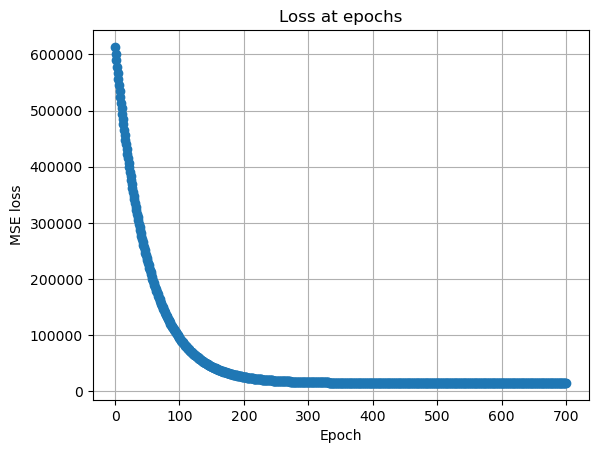

In [17]:
train_and_test(
    model, train_matrix, train_labels_matrix, test_matrix, test_labels_matrix
)

# Ordinary with L2 regularization

In [18]:
base_func_reg_L2 = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func_reg_L2 = MSE(train_matrix.shape[0])


model = Model(base_func_reg_L2, loss_func_reg_L2, 0.01, L2_regularization)

15022.537674156792
2899.9875540335447


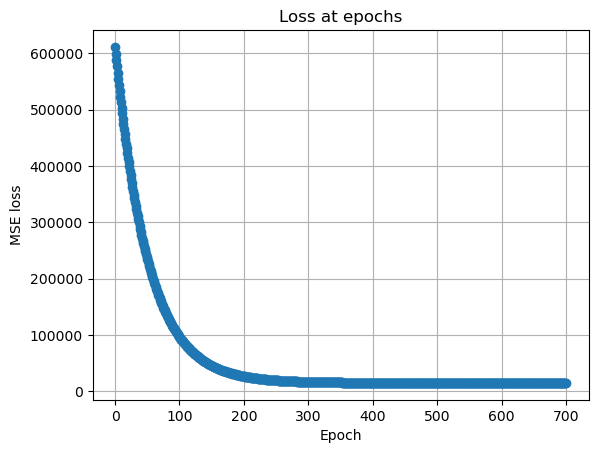

In [19]:
train_and_test(
    model, train_matrix, train_labels_matrix, test_matrix, test_labels_matrix
)
# &&
base_func_reg_L1 = OrdinaryBaseFunc(train_matrix.shape[1], train_matrix.shape[0])
loss_func_reg_L1 = MSE(train_matrix.shape[0])


model = Model(base_func_reg_L1, loss_func_reg_L1, 0.01, L1_regularization)

14811.040962730576
2944.0794049873307


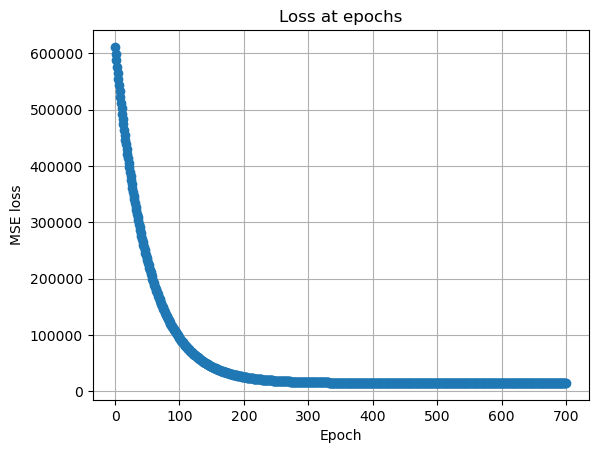

In [20]:
train_and_test(
    model, train_matrix, train_labels_matrix, test_matrix, test_labels_matrix
)